<a href="https://colab.research.google.com/github/PauloDaguvnor/RFM-Analysis/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Relevant Libraries
import scipy
import numpy as np
import datetime as dt
import matplotlib
import pandas as pd
import statsmodels
import sklearn

In [ ]:
#Load and View The Dataset
data  = pd.read_csv('/content/sample_data/Groceries_dataset.csv')
data.head(5)

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


# Data Pre-processing

In [ ]:
#Check for Null values
data.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [ ]:
#Checking Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [ ]:
#Statistically Describe the dataset
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Member_number,38765.0,3003.641868,1153.611031,1000.0,2002.0,3005.0,4007.0,5000.0


In [ ]:
#Product Distribution
pdata = data[['itemDescription','Member_number']].drop_duplicates()
ppdata= pdata.groupby(['itemDescription'])['Member_number'].aggregate('count').reset_index().sort_values('Member_number', ascending= False)
ppdata

,itemDescription,Member_number
164,whole milk,1786
102,other vegetables,1468
122,rolls/buns,1363
138,soda,1222
165,yogurt,1103
...,...,...
86,make up remover,5
5,bags,4
4,baby cosmetics,3
79,kitchen utensil,1


In [ ]:
data['Date'].max()

Timestamp('2015-12-30 00:00:00')

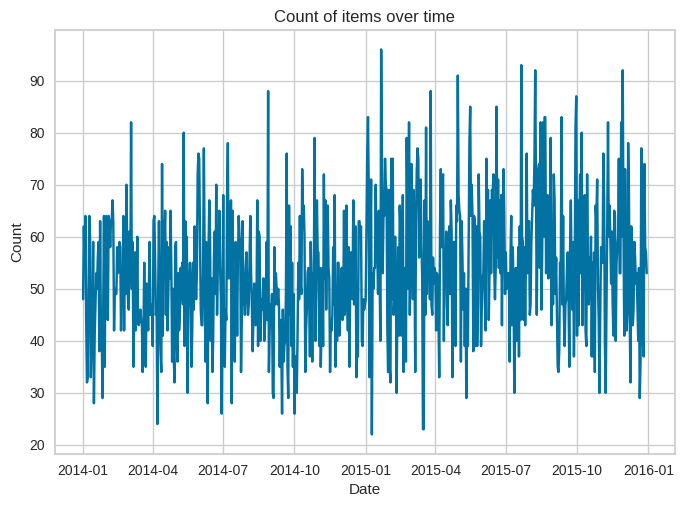

In [ ]:
# group the data
counts = data.groupby('Date')['itemDescription'].count()

# plot the data
plt.plot(counts.index, counts.values)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count of items over time')
plt.show()

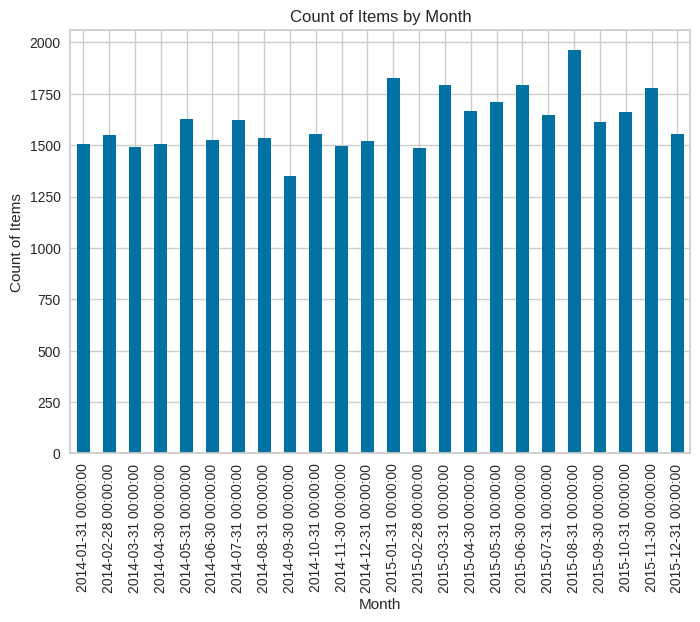

In [ ]:
# Group by month and count the items in each month
monthly_counts = data.groupby(pd.Grouper(key='Date', freq='M'))['itemDescription'].count()

# Plot the column chart
monthly_counts.plot(kind='bar')
plt.title('Count of Items by Month')
plt.xlabel('Month')
plt.ylabel('Count of Items')
plt.show()

In [ ]:
#Change format to date
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-7-e738bc858509>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
#Data Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


# Load the Data to SQLlite

In [ ]:
#Set up and Read the data
import pandas as pd
import sqlite3

# read csv file
df_Fact = pd.read_csv('/content/sample_data/Groceries_dataset.csv')

# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()

# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn)

# CHECK IF DATA INSERTED INTO data/RFMdb
df_Fact = pd.read_sql('SELECT * FROM data', conn)
df_Fact


,index,Member_number,Date,itemDescription
0,0,1808,21-07-2015,tropical fruit
1,1,2552,05-01-2015,whole milk
2,2,2300,19-09-2015,pip fruit
3,3,1187,12-12-2015,other vegetables
4,4,3037,01-02-2015,whole milk
...,...,...,...,...
38760,38760,4471,08-10-2014,sliced cheese
38761,38761,2022,23-02-2014,candy
38762,38762,1097,16-04-2014,cake bar
38763,38763,1510,03-12-2014,fruit/vegetable juice


In [ ]:
# clean data and group transactions by Customerid
cleandata= pd.read_sql(''' SELECT Member_number,
                   MAX(Date) AS last_order_date,
                   COUNT(DISTINCT([Date])) AS count_order,
                   COUNT(itemDescription) AS m_value
            FROM data
            GROUP BY Member_number ''', conn)

# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)


3898

In [ ]:
df_Fact2 = pd.read_sql('SELECT * FROM cleandata', conn)
df_Fact2

,index,Member_number,last_order_date,count_order,m_value
0,0,1000,27-05-2015,5,13
1,1,1001,20-01-2015,5,12
2,2,1002,30-08-2015,4,8
3,3,1003,27-02-2014,4,8
4,4,1004,19-08-2014,8,21
...,...,...,...,...,...
3893,3893,4996,24-11-2015,3,10
3894,3894,4997,27-12-2015,2,6
3895,3895,4998,14-10-2015,1,2
3896,3896,4999,26-12-2015,6,16


In [ ]:
# Check the data types
df_Fact2.dtypes
df_Fact2['last_order_date'] = pd.to_datetime(df_Fact2['last_order_date'])
df_Fact2.dtypes


<ipython-input-13-673e384c6933>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_Fact2['last_order_date'] = pd.to_datetime(df_Fact2['last_order_date'])


index                       int64
Member_number               int64
last_order_date    datetime64[ns]
count_order                 int64
m_value                     int64
dtype: object

In [ ]:
# Create date variable that records recency
import numpy as np
import datetime
df_Fact2["last_order_date"] = df_Fact2["last_order_date"].dt.date
# Create snapshot date
snapshot_date = df_Fact2['last_order_date'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Aggregate data by each customer
customers = df_Fact2.groupby(['Member_number']).agg({
   'last_order_date': lambda x: (snapshot_date - x.max()).days,
   'count_order':'sum' ,
   'm_value': 'sum'})

# Rename columns
customers.rename(columns = {'last_order_date': 'Recency',
                            'count_order': 'Frequency',
                            'm_value': 'MonetaryValue'}, inplace=True)

2015-12-31


In [ ]:
#View the RFM values for the Customers
customers

,Recency,Frequency,MonetaryValue
Member_number,,,
1000,218,5,13
1001,345,5,12
1002,123,4,8
1003,672,4,8
1004,499,8,21
...,...,...,...
4996,37,3,10
4997,4,2,6
4998,78,1,2


Text(0.5, 1.0, 'Histogram of Recency')

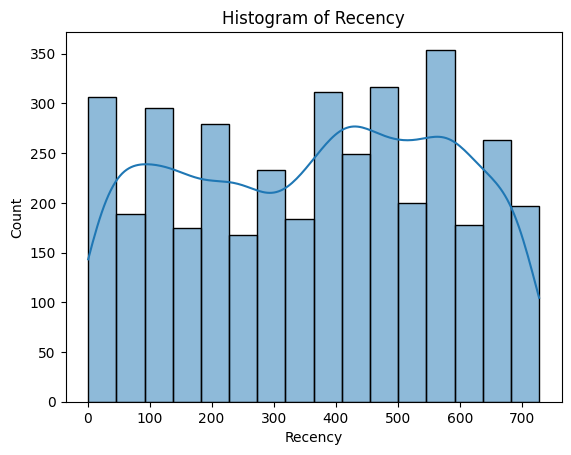

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Recency', kde=True)
ax.set_title('Histogram of Recency')

Text(0.5, 1.0, 'Histogram of Frequency')

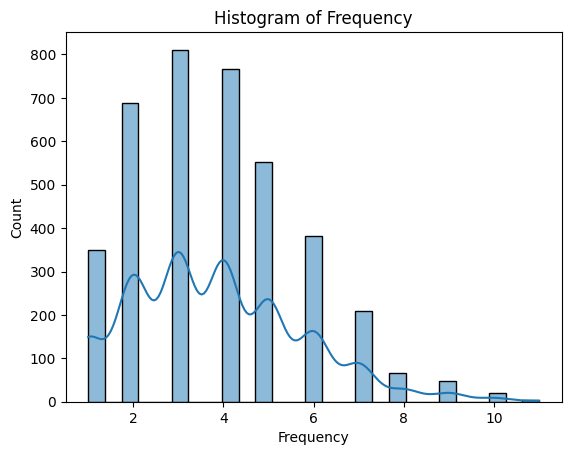

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Frequency', kde=True)
ax.set_title('Histogram of Frequency')

Text(0.5, 1.0, 'Histogram of MonetaryValue')

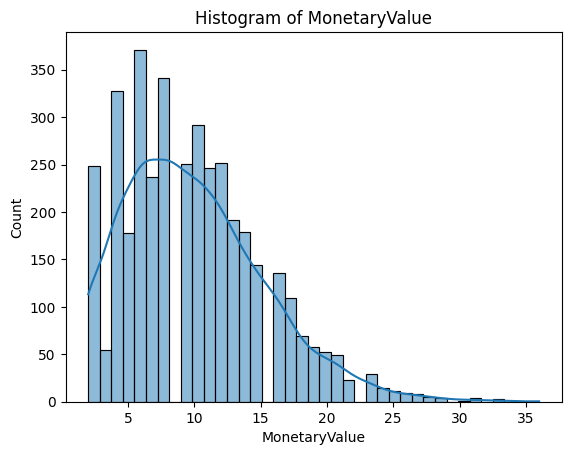

In [ ]:
#Check whether the RFM values Satisfies the Normality Assumption
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='MonetaryValue', kde=True)
ax.set_title('Histogram of MonetaryValue')

<ipython-input-19-a7e08f6e9151>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
<ipython-input-19-a7e08f6e9151>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
<ipython-input-19-a7e08f6e9151>:8: UserWarni

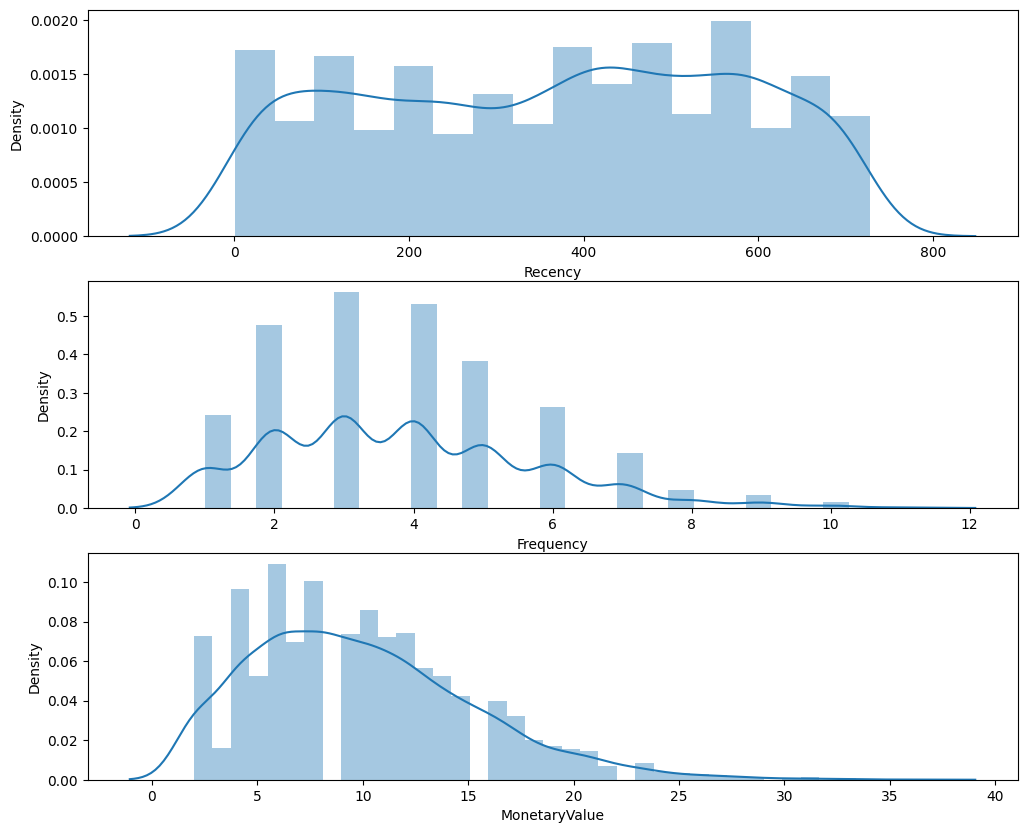

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers['MonetaryValue'])
# Show the plot
plt.show()

In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(customers['MonetaryValue'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue
3893,17.582793,1.412097,3.847542
3894,2.391512,0.810273,2.654617
3895,31.211451,0.000000,0.802660
3896,3.054496,2.725071,5.191431
3897,107.383666,1.412097,2.988455


<ipython-input-21-edbcbb4b2927>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
<ipython-input-21-edbcbb4b2927>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
<ipython-input-21-edbcbb4b2927>:8: U

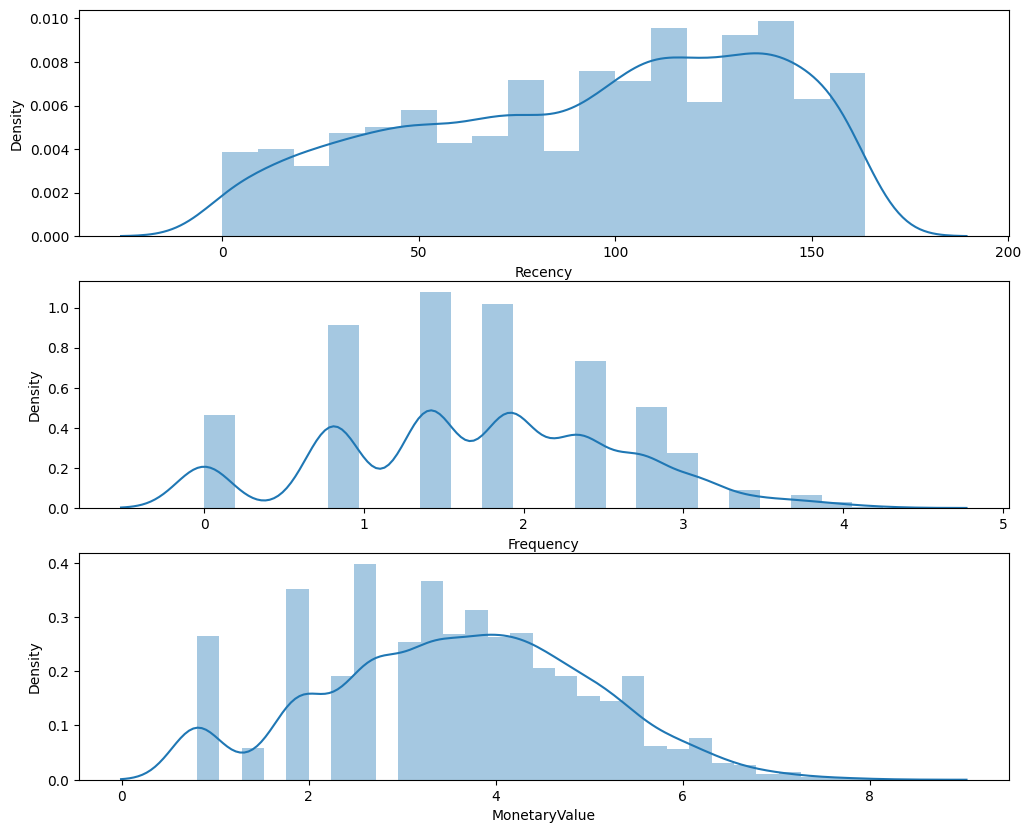

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(customers_fix['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(customers_fix['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(customers_fix['MonetaryValue'])
# Show the plot
plt.show()

# Normalize the dataset

In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0. -0. -0.]
[1. 1. 1.]


Find the Number of Optimal Number of Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

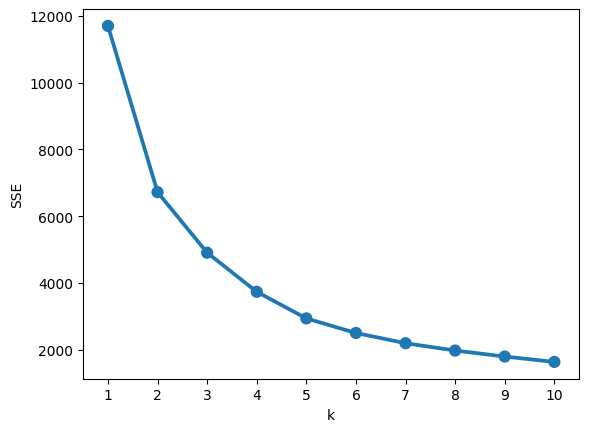

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroidplt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

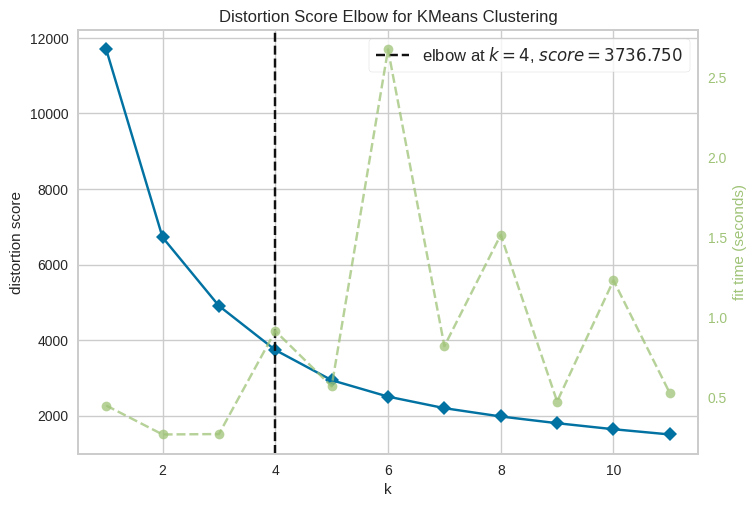

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Another Method to find the no of clusters: Use a readymade utility
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model,k=(1,12))
visualizer.fit(customers_normalized)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,MonetaryValue
Cluster,,,
0,886,886,886
1,854,854,854
2,944,944,944
3,1214,1214,1214


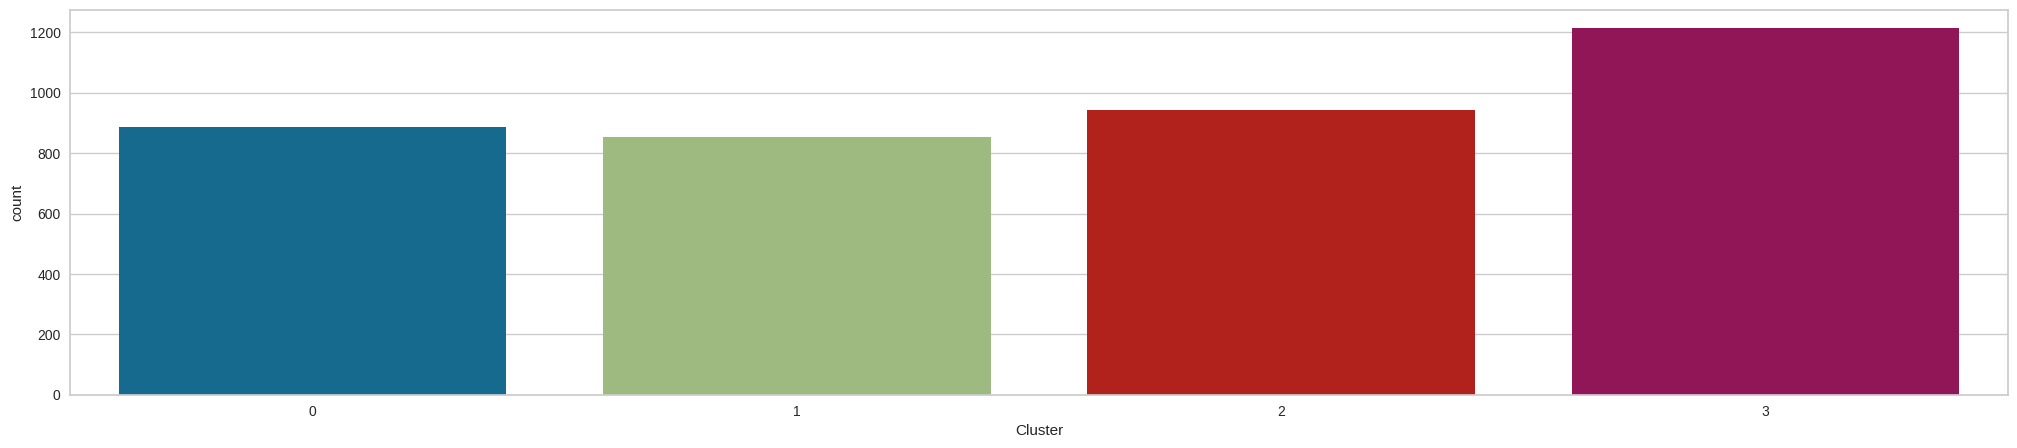

In [ ]:
#We run KMeans for using the optimal number of clusters derived
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
'Recency':'mean',
'Frequency':'mean',
'MonetaryValue':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

In [ ]:
#Display the RFM values for each cluster
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        373.47      6.42         17.17   886
1        398.49      1.60          3.83   854
2        118.18      3.56          9.51   944
3        520.95      3.75          9.31  1214

In [ ]:
#View the customers RFM scores and their clusters
customers

,Recency,Frequency,MonetaryValue,Cluster
Member_number,,,,
1000,218,5,13,0
1001,345,5,12,0
1002,123,4,8,2
1003,672,4,8,3
1004,499,8,21,0
...,...,...,...,...
4996,37,3,10,2
4997,4,2,6,2
4998,78,1,2,1


<Axes: xlabel='Attribute', ylabel='Value'>

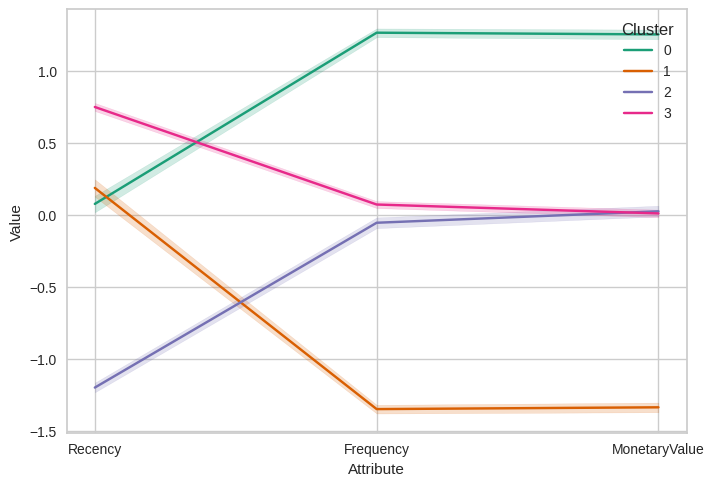

In [ ]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x= 'Attribute', y = 'Value', hue='Cluster',palette = 'Dark2', data=df_nor_melt)